In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import sqlite3

players = pd.read_csv('./Dataset/players.csv')
teams = pd.read_csv('./Dataset/teams.csv')
players_teams = pd.read_csv('./Dataset/players_teams.csv')
awards_players = pd.read_csv('./Dataset/awards_players.csv')
coaches = pd.read_csv('./Dataset/coaches.csv')
series_post = pd.read_csv('./Dataset/series_post.csv')
teams_post = pd.read_csv('./Dataset/teams_post.csv')

db_path = 'data.db'
connection = sqlite3.connect(db_path)

queryTeams = "SELECT * FROM teams"
#teams = pd.read_sql_query(queryTeams, connection)

### Awards_players


- corrected name of a prize
- drop lgID
- calculate the number of prizes that each player has (having in consideration the year)
- drop award (name)

In [2]:
awards_players['award'] = awards_players['award'].replace("Kim Perrot Sportsmanship", "Kim Perrot Sportsmanship Award")
awards_players = awards_players.drop(columns=['lgID'], axis=1)

award_weights = {
    "All-Star Game Most Valuable Player": 2,
    "Coach of the Year": 3,
    "Defensive Player of the Year": 4,
    "Kim Perrot Sportsmanship Award": 1,
    "Most Improved Player": 2,
    "Most Valuable Player": 5,
    "Rookie of the Year": 3,
    "Sixth Woman of the Year": 2,
    "WNBA Finals Most Valuable Player": 4,
    "WNBA All-Decade Team": 1,
    "WNBA All Decade Team Honorable Mention": 1,
}

# Sort the DataFrame by playerID and year
awards_players.sort_values(by=["playerID", "year"], inplace=True)

awards_players['award_weight'] = awards_players['award'].map(award_weights)
awards_players['num_prizes'] = awards_players.groupby('playerID')['award_weight'].cumsum()
awards_players = awards_players.drop_duplicates(subset=['playerID', 'year'], keep='last')

awards_players = awards_players.drop(columns=['award', 'award_weight'], axis=1)

awards_players.to_csv('./Modified/modified_awards.csv', index=False)


### Players

- drop college, collegeOther, pos and lastseason
- remove who has height = 0
- replace height error (9) with the average
- replace weight error (0) with the average


In [3]:
players = players.drop('college', axis=1)
players = players.drop('pos', axis=1)
players = players.drop('collegeOther', axis=1)
# Have only 0s
players = players.drop('lastseason', axis=1)
players = players.drop('firstseason', axis=1)

players = players[players['height'] > 0]

# Calculate the mean of non-zero heights
mean_height = players[(players['height'] != 0) | (players['height'] != 9)]['height'].mean()
# Replace 9 with the mean height
players['height'] = players['height'].replace(9, mean_height)

# Calculate the mean of non-zero weights
mean_weight = players[players['weight'] != 0]['weight'].mean()
players['weight'] = players['weight'].replace(0, mean_weight)


### Players_teams

- statistics: info about the previous year
    - if never appeared before, null ( we doesnt know anything about that player at the beginning of the season)

In [4]:
players_teams = players_teams.drop(columns=['lgID', 'PostGP','PostGS','PostMinutes','PostPoints','PostoRebounds','PostdRebounds','PostRebounds','PostAssists','PostSteals','PostBlocks','PostTurnovers','PostPF','PostfgAttempted','PostfgMade','PostftAttempted','PostftMade','PostthreeAttempted','PostthreeMade','PostDQ'], axis=1)
players_teams.sort_values(by=["playerID", "year", "stint"], inplace=True)
testing_set_with_stats = pd.DataFrame()

previous_columns = ['GP', 'GS', 'minutes', 'points', 'oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF', 'fgAttempted', 'fgMade', 'ftAttempted', 'ftMade', 'threeAttempted', 'threeMade', 'dq']

players = players.rename(columns={'bioID': 'playerID'})

for year in range(2,11):

    players_in_year = players_teams[players_teams['year'] == year]

    players_in_year = players_teams[players_teams['playerID'].isin(players_in_year['playerID'])]

    players_in_year = players_in_year[players_in_year['year'] < year]

    last_season_per_player = players_in_year.groupby('playerID')['year'].max().reset_index()

    last_season_stats = players_teams.merge(last_season_per_player, on=['playerID', 'year'], how='right')

    last_year_sum = last_season_stats.groupby('playerID').sum()[previous_columns].reset_index()

    testing_set_for_year = last_year_sum.merge(players, on='playerID', how='left')
    
    testing_set_for_year['year'] = year

    testing_set_with_stats = pd.concat([testing_set_with_stats, testing_set_for_year], ignore_index=True)
    

players_teams= players_teams[['playerID', 'year', 'tmID']]

testing_set_with_stats = testing_set_with_stats.merge(players_teams, on=['playerID', 'year'], how='right')


players_teams = testing_set_with_stats

players_teams = players_teams.dropna(thresh=6, axis=0)

testing_set_with_stats.to_csv('./Modified/testing.csv', index=False)


In [5]:
"""grouped = players_teams.groupby(['playerID', 'year'], as_index=False)
summed_stats = players_teams.groupby(['playerID', 'year'])[['GP', 'GS', 'minutes', 'points', 'oRebounds', 'dRebounds', 'rebounds', 
                        'assists', 'steals', 'blocks', 'turnovers', 'PF', 'fgAttempted', 
                        'fgMade', 'ftAttempted', 'ftMade', 'threeAttempted', 'threeMade', 'dq', 'stint']].sum().reset_index()

summed_stats.to_csv('./Modified/summed_stats.csv', index=False)
"""

"grouped = players_teams.groupby(['playerID', 'year'], as_index=False)\nsummed_stats = players_teams.groupby(['playerID', 'year'])[['GP', 'GS', 'minutes', 'points', 'oRebounds', 'dRebounds', 'rebounds', \n                        'assists', 'steals', 'blocks', 'turnovers', 'PF', 'fgAttempted', \n                        'fgMade', 'ftAttempted', 'ftMade', 'threeAttempted', 'threeMade', 'dq', 'stint']].sum().reset_index()\n\nsummed_stats.to_csv('./Modified/summed_stats.csv', index=False)\n"

In [6]:
"""players_teams = players_teams.drop(columns=['lgID', 'PostGP','PostGS','PostMinutes','PostPoints','PostoRebounds','PostdRebounds','PostRebounds','PostAssists','PostSteals','PostBlocks','PostTurnovers','PostPF','PostfgAttempted','PostfgMade','PostftAttempted','PostftMade','PostthreeAttempted','PostthreeMade','PostDQ'], axis=1)

players_teams.sort_values(by=["playerID", "year"], inplace=True)

previous_columns = ['GP', 'GS', 'minutes', 'points', 'oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF', 'fgAttempted', 'fgMade', 'ftAttempted', 'ftMade', 'threeAttempted', 'threeMade', 'dq']

# Calculate the previous for each column over the rolling window
for col in previous_columns:
    players_teams[f'previous_{col}'] = players_teams.groupby('playerID')[col].shift(1).rolling(window=2, min_periods=1).mean().reset_index(level=0, drop=True)
    
    
#players_teams[f'previous_{col}'] = players_teams.groupby('playerID')[col].shift(1).rolling(window=2, min_periods=1).mean().reset_index(level=0, drop=True)


players_teams.drop(previous_columns, axis=1, inplace=True)"""

'players_teams = players_teams.drop(columns=[\'lgID\', \'PostGP\',\'PostGS\',\'PostMinutes\',\'PostPoints\',\'PostoRebounds\',\'PostdRebounds\',\'PostRebounds\',\'PostAssists\',\'PostSteals\',\'PostBlocks\',\'PostTurnovers\',\'PostPF\',\'PostfgAttempted\',\'PostfgMade\',\'PostftAttempted\',\'PostftMade\',\'PostthreeAttempted\',\'PostthreeMade\',\'PostDQ\'], axis=1)\n\nplayers_teams.sort_values(by=["playerID", "year"], inplace=True)\n\nprevious_columns = [\'GP\', \'GS\', \'minutes\', \'points\', \'oRebounds\', \'dRebounds\', \'rebounds\', \'assists\', \'steals\', \'blocks\', \'turnovers\', \'PF\', \'fgAttempted\', \'fgMade\', \'ftAttempted\', \'ftMade\', \'threeAttempted\', \'threeMade\', \'dq\']\n\n# Calculate the previous for each column over the rolling window\nfor col in previous_columns:\n    players_teams[f\'previous_{col}\'] = players_teams.groupby(\'playerID\')[col].shift(1).rolling(window=2, min_periods=1).mean().reset_index(level=0, drop=True)\n    \n    \n#players_teams[f\'pr

- add a column called Age, considering the year of the season. Calculated through the merge between two datasets~
- number of prizes of each player (according to the year)
- drop birthdate and deathdate


In [7]:
def calculate_age(row):
    birth_year = int(row['birthDate'][:4])
    age = 2000 + row['year'] - birth_year
    return age


merged_data = players_teams.merge(awards_players, on=['playerID', 'year'], how='left')

merged_data['num_prizes'] = merged_data.groupby('playerID')['num_prizes'].ffill()

merged_data['num_prizes'] = merged_data.groupby('playerID')['num_prizes'].shift(1)

# Fill NaN values with 0 for players with no prizes 
merged_data['num_prizes'].fillna(0, inplace=True)

# Apply the function to each row
merged_data['age'] = merged_data.apply(calculate_age, axis=1)


merged_data = merged_data.drop('birthDate', axis=1)
merged_data = merged_data.drop('deathDate', axis=1)


### Coaches

- drop lgID, stint, post_wins and post_losses
- create column num_prizes (merging awards_players)

In [8]:
coaches = coaches.drop(columns=['lgID'], axis=1)
#coaches = coaches.drop(columns=['stint'], axis=1)

coaches = coaches.merge(awards_players, left_on=['coachID', 'year'], right_on=['playerID', 'year'], how='left')
coaches.sort_values(by=["coachID", "year"], inplace=True)

coaches['num_prizes'] = coaches.groupby('coachID')['num_prizes'].ffill()

# Fill NaN values with 0 for players with no prizes 
coaches['num_prizes'].fillna(0, inplace=True)

coaches['num_prizes'] = coaches.groupby('coachID')['num_prizes'].shift(1)

coaches['num_prizes'].fillna(0, inplace=True)


coaches['won'] = coaches.groupby('coachID')['won'].shift(1)
coaches['lost'] = coaches.groupby('coachID')['lost'].shift(1)

coaches['won'].fillna(0, inplace=True)
coaches['lost'].fillna(0, inplace=True)

coaches['post_wins'] = coaches.groupby('coachID')['post_wins'].shift(1)
coaches['post_losses'] = coaches.groupby('coachID')['post_losses'].shift(1)

coaches['post_wins'].fillna(0, inplace=True)
coaches['post_losses'].fillna(0, inplace=True)


coaches = coaches.drop(columns=['playerID'], axis=1)

coaches.to_csv('./Modified/modified_coaches.csv', index=False)



### Teams

- drop seeded, confID, divID, franchID, arena, lgID and name
- corrected error: one season it was registered two winners

In [9]:
teams = teams.drop(columns=['seeded', 'divID', 'franchID', 'arena', 'lgID', 'name', 'tmORB'], axis=1)
teams = teams.drop(columns=['tmDRB'], axis=1)
teams = teams.drop(columns=['tmTRB'], axis=1)
teams = teams.drop(columns=['opptmORB'], axis=1)
teams = teams.drop(columns=['opptmDRB'], axis=1)
teams = teams.drop(columns=['opptmTRB'], axis=1)
#teams = teams.drop(columns=['confID'], axis=1)


stats_teams = ['o_fgm','o_fga','o_ftm','o_fta','o_3pm','o_3pa','o_oreb','o_dreb','o_reb','o_asts','o_pf','o_stl','o_to','o_blk','o_pts','d_fgm','d_fga','d_ftm','d_fta','d_3pm','d_3pa','d_oreb','d_dreb','d_reb','d_asts','d_pf','d_stl','d_to','d_blk','d_pts','GP','homeW','homeL','awayW','awayL','confW','confL','min']
teams = teams.drop(columns=stats_teams, axis=1)

columns_to_shift = ['won', 'lost', 'attend', 'rank']
columns_post = ['firstRound', 'semis', 'finals']

teams.sort_values(by=["tmID", "year"])

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

""" for col in ['attend']:
    teams[f'prev_{col}'] = teams.groupby('tmID')[col].shift(1)
    teams[f'prev_{col}'].fillna(0, inplace=True) """


# Group by team and shift the specified columns to get the previous year's values
for col in columns_post:
    teams[f'prev_{col}'] = label_encoder.fit_transform(teams.groupby('tmID')[col].shift(1))


teams = teams.drop(columns=columns_post, axis=1)

teams = teams.drop(columns=columns_to_shift, axis=1)


- calculate the number of prizes a team has (total of prizes the players have), creating the column num_prizes

In [10]:

teams.sort_values(by=["tmID", "year"])

playerAndTeams = merged_data.merge(teams, on=["tmID", "year"])

# Group by team and year, summing the number of prizes
team_prizes = playerAndTeams.groupby(['tmID', 'year'])['num_prizes'].sum().reset_index()

# Sort the result by year
team_prizes.sort_values(by='year', inplace=True)

teams = teams.merge(team_prizes, on=["tmID", "year"])


- calculate the sum of the statistics of the players of each team

In [11]:
# Define the columns to sum
#sum_columns = ['previous_GP', 'previous_GS', 'previous_minutes', 'previous_points', 'previous_oRebounds', 'previous_dRebounds', 'previous_rebounds', 'previous_assists', 'previous_steals', 'previous_blocks', 'previous_turnovers', 'previous_PF', 'previous_fgAttempted', 'previous_fgMade', 'previous_ftAttempted', 'previous_ftMade', 'previous_threeAttempted', 'previous_threeMade', 'previous_dq']

sum_columns = ['GP', 'GS', 'minutes', 'points', 'oRebounds', 'dRebounds', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF', 'fgAttempted', 'fgMade', 'ftAttempted', 'ftMade', 'threeAttempted', 'threeMade', 'dq']

# Sum the columns for each team and year
summed_columns = playerAndTeams.groupby(['tmID', 'year'])[sum_columns].sum().reset_index()

summed_columns.columns = ['tmID', 'year'] + ['sum_' + col for col in sum_columns]

# Merge the summed columns back into the 'teams' table
teams = pd.merge(teams, summed_columns, how='left', on=['tmID', 'year'])


- calculate the mean of the height, weight and age of the players of each team

In [12]:

team_means = playerAndTeams.groupby(['tmID', 'year']).agg({
    'height': 'mean',
    'weight': 'mean',
    'age': 'mean',
}).reset_index()
teams = pd.merge(teams, team_means, on=['tmID', 'year'], how='left')


- add to the table teams the number of prizes the coach has (sum it in the column num_prizes)

In [13]:
teams = pd.merge(teams, coaches[['tmID', 'year', 'won', 'lost']], on=['tmID', 'year'], how='left')

teams = pd.merge(teams, coaches[['tmID', 'year', 'post_wins', 'post_losses']], on=['tmID', 'year'], how='left')


merged_df = pd.merge(teams, coaches, on=['year', 'tmID'], how='left')

merged_df['num_prizes_y'] = merged_df['num_prizes_y'].fillna(0)

teams['coaches_prizes'] = merged_df['num_prizes_y']


In [14]:
teams.to_csv('./Modified/modified_teams.csv', index=False)

- enconde categorical columns
- split data

In [15]:
from sklearn.preprocessing import LabelEncoder

# Encode the 'playoff' column
label_encoder = LabelEncoder()
teams['playoff'] = label_encoder.fit_transform(teams['playoff'])
teams['tmID'] = label_encoder.fit_transform(teams['tmID'])
teams['confID'] = label_encoder.fit_transform(teams['confID'])


train_data = teams[teams['year'] <= 9]
test_data = teams[teams['year'] == 10]

Logistic Regression Performance Metrics:
Accuracy: 0.6818181818181818
ROC AUC: 0.8595041322314051
Confusion Matrix:
[[6 5]
 [2 9]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.64      0.82      0.72        11

    accuracy                           0.68        22
   macro avg       0.70      0.68      0.68        22
weighted avg       0.70      0.68      0.68        22



c:\Users\diogo\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


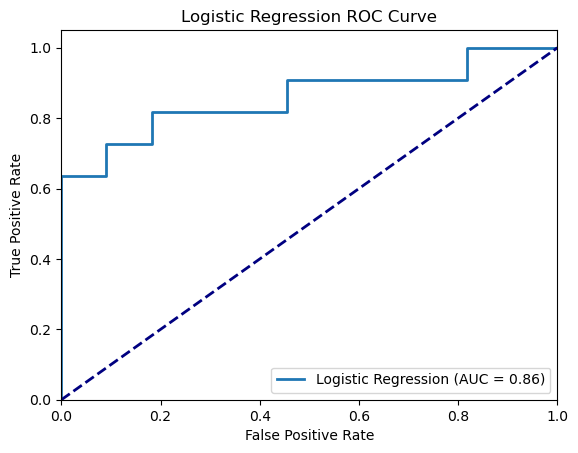

Support Vector Machine Performance Metrics:
Accuracy: 0.7272727272727273
ROC AUC: 0.8264462809917356
Confusion Matrix:
[[9 2]
 [4 7]]
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.82      0.75        11
           1       0.78      0.64      0.70        11

    accuracy                           0.73        22
   macro avg       0.74      0.73      0.73        22
weighted avg       0.74      0.73      0.73        22



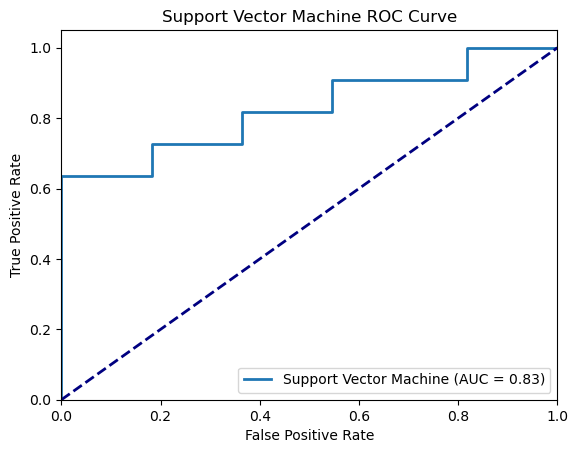

Decision Tree Performance Metrics:
Accuracy: 0.9090909090909091
ROC AUC: 0.9090909090909091
Confusion Matrix:
[[ 9  2]
 [ 0 11]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.85      1.00      0.92        11

    accuracy                           0.91        22
   macro avg       0.92      0.91      0.91        22
weighted avg       0.92      0.91      0.91        22



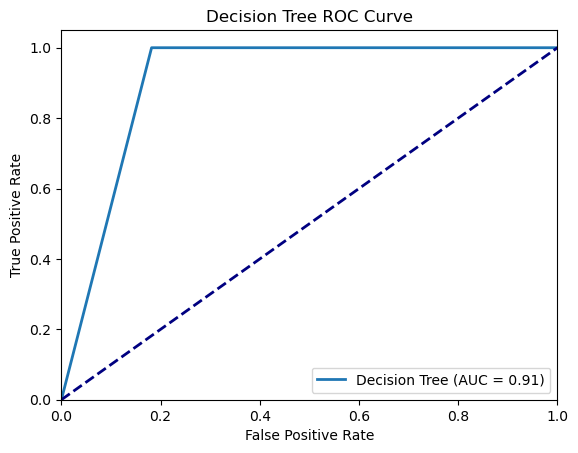

Random Forest Performance Metrics:
Accuracy: 0.6363636363636364
ROC AUC: 0.7479338842975207
Confusion Matrix:
[[ 4  7]
 [ 1 10]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.36      0.50        11
           1       0.59      0.91      0.71        11

    accuracy                           0.64        22
   macro avg       0.69      0.64      0.61        22
weighted avg       0.69      0.64      0.61        22



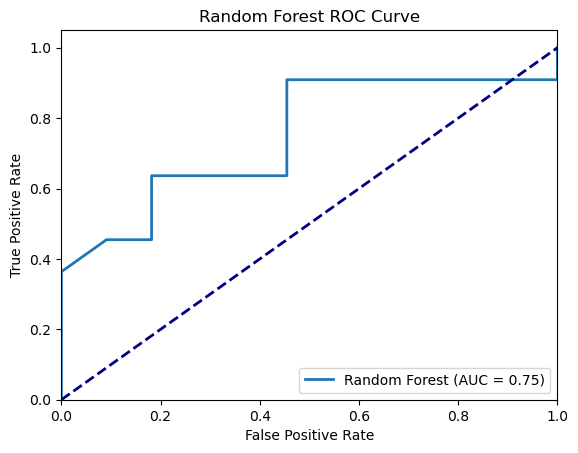

K-Nearest Neighbors Performance Metrics:
Accuracy: 0.6818181818181818
ROC AUC: 0.5371900826446281
Confusion Matrix:
[[ 5  6]
 [ 1 10]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.45      0.59        11
           1       0.62      0.91      0.74        11

    accuracy                           0.68        22
   macro avg       0.73      0.68      0.66        22
weighted avg       0.73      0.68      0.66        22



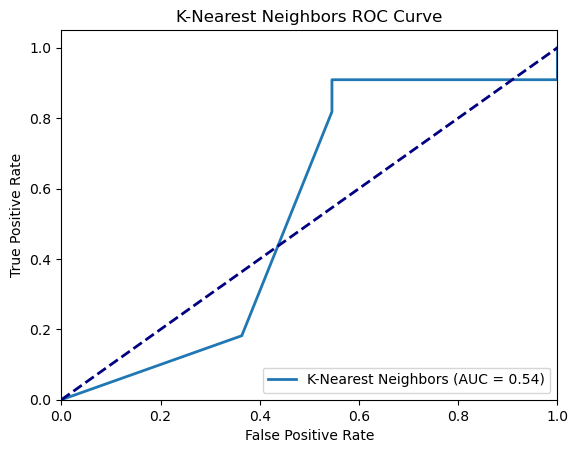

Naive Bayes Performance Metrics:
Accuracy: 0.5
ROC AUC: 0.5454545454545454
Confusion Matrix:
[[2 9]
 [2 9]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.18      0.27        11
           1       0.50      0.82      0.62        11

    accuracy                           0.50        22
   macro avg       0.50      0.50      0.44        22
weighted avg       0.50      0.50      0.44        22



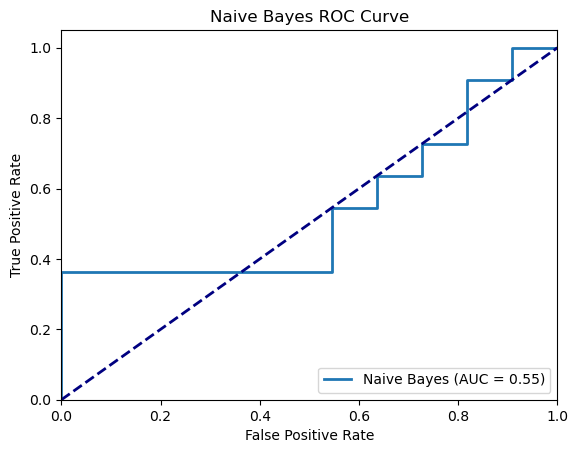

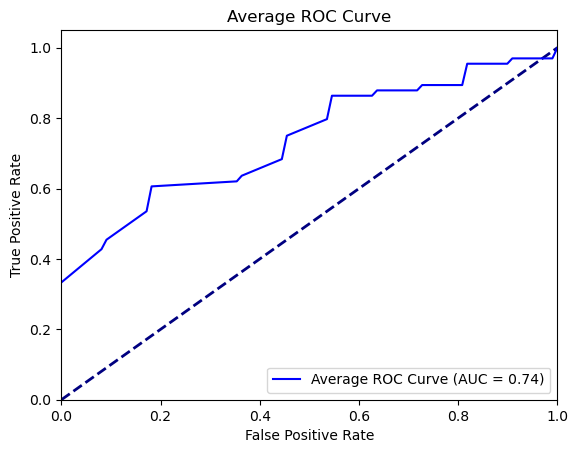

Average Accuracy: 0.69
Average ROC AUC: 0.74


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import numpy as np

# Use the same train_data and test_data from your code
X_train = train_data.drop(['playoff'], axis=1)
y_train = train_data['playoff']
X_test = test_data.drop(['playoff'], axis=1)
y_test = test_data['playoff']

# Define a list of classifiers
classifiers = [
    ("Logistic Regression", LogisticRegression(solver='liblinear', random_state=0)),
    ("Support Vector Machine", SVC(kernel='linear', random_state=0)),
    ("Decision Tree", DecisionTreeClassifier(random_state=0)),
    ("Random Forest", RandomForestClassifier(random_state=0)),
    ("K-Nearest Neighbors", KNeighborsClassifier()),
    ("Naive Bayes", GaussianNB())
]

# Create an empty dictionary to store performance metrics
performance_metrics = {}
roc_curve_data = []

# Initialize variables to calculate averages
average_accuracy = 0
average_roc_auc = 0

# Iterate through each classifier, train, predict, and store performance metrics
for name, clf in classifiers:
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    average_accuracy += accuracy

    # Calculate ROC curve and AUC
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_test)[:, 1]
    else:
        y_score = clf.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    average_roc_auc += roc_auc

    # Store performance metrics in a dictionary
    performance_metrics[name] = {
        "Accuracy": accuracy,
        "ROC AUC": roc_auc,
        "Confusion Matrix": confusion_matrix(y_test, predictions),
        "Classification Report": classification_report(y_test, predictions),
        "ROC Curve": (fpr, tpr)
    }
    # Append ROC curve data for later averaging
    roc_curve_data.append((fpr, tpr))

# Calculate averages
average_accuracy /= len(classifiers)
average_roc_auc /= len(classifiers)

# Print the performance metrics and create ROC curve graphs
for name, metrics in performance_metrics.items():
    print(f"{name} Performance Metrics:")
    print(f"Accuracy: {metrics['Accuracy']}")
    print(f"ROC AUC: {metrics['ROC AUC']}")
    print("Confusion Matrix:")
    print(metrics['Confusion Matrix'])
    print("Classification Report:")
    print(metrics['Classification Report'])

    # Plot ROC Curve
    plt.figure()
    fpr, tpr = metrics["ROC Curve"]
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {metrics["ROC AUC"]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Calculate and plot the average ROC curve
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr in roc_curve_data], axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Average ROC Curve (AUC = {mean_auc:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Print averages
print(f"Average Accuracy: {average_accuracy:.2f}")
print(f"Average ROC AUC: {average_roc_auc:.2f}")


In [17]:
logreg = LogisticRegression(solver='liblinear', random_state=0)
logreg.fit(X_train, y_train)

# Step 6: Make predictions
y_pred = logreg.predict(X_test)

inputs = teams.columns
feature_importance = abs(logreg.coef_[0])
feature_importance = sorted(zip(inputs, feature_importance), key=lambda x: x[1], reverse=True)

print("Feature importance:")
for i in range(len(feature_importance)):
    print(f"{feature_importance[i][0]}: {feature_importance[i][1]}")

Feature importance:
prev_firstRound: 0.7758434281759775
prev_semis: 0.5942962019547472
sum_dq: 0.5303555537898555
post_losses: 0.4078393200048701
lost: 0.2986976797088406
year: 0.1825325030345461
height: 0.18049073737385568
playoff: 0.16875348507894844
post_wins: 0.145070190029587
prev_finals: 0.12470061941613604
confID: 0.08896335763414236
num_prizes: 0.0833567589097949
won: 0.07046243721067644
weight: 0.05623531051063233
sum_threeMade: 0.055866174410230694
tmID: 0.044869141005480645
sum_threeAttempted: 0.04207302274710687
sum_ftMade: 0.030687824990821407
sum_fgAttempted: 0.025329866397319354
sum_GP: 0.017566649461084573
sum_ftAttempted: 0.017234290351216
sum_steals: 0.015092370839639614
sum_fgMade: 0.013123488716315891
sum_dRebounds: 0.012547575832268301
sum_rebounds: 0.010100818100907065
sum_minutes: 0.008647580303959342
sum_oRebounds: 0.008145780797989638
sum_PF: 0.0070329190728444235
sum_turnovers: 0.00506985562229798
sum_points: 0.0044017950317930595
sum_assists: 0.00230394818570

In [18]:
merged_data.to_csv('./Modified/players_playersTeams.csv', index=False)

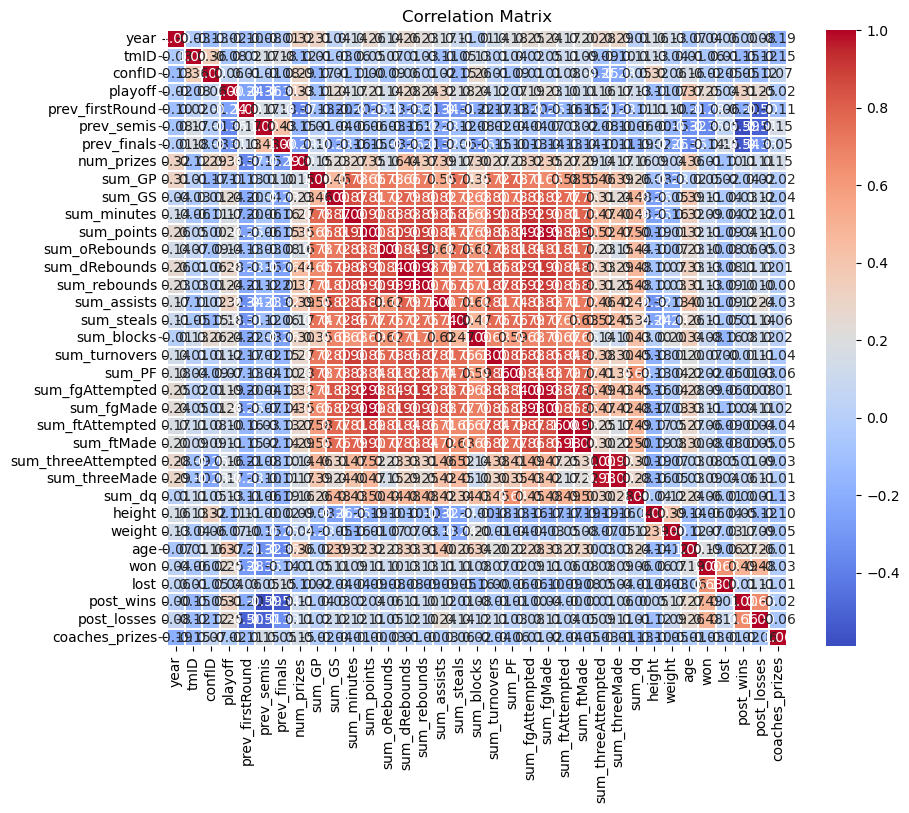

In [19]:
# Create a correlation matrix for all columns
correlation_matrix = train_data.corr()

# Set the size of the heatmap
plt.figure(figsize=(10, 8))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.3)

# Set the title
plt.title("Correlation Matrix")

# Show the heatmap
plt.show()

In [20]:
""" teams_before = pd.read_csv('./Dataset/teams.csv')

print(teams_before.columns)
teams_before['playoff'] = label_encoder.fit_transform(teams_before['playoff'])
#teams['previous_playoff'] = label_encoder.fit_transform(teams['previous_playoff'])
teams_before['tmID'] = label_encoder.fit_transform(teams_before['tmID'])
teams_before['confID'] = label_encoder.fit_transform(teams_before['confID'])
teams_before['lgID'] = label_encoder.fit_transform(teams_before['lgID'])
teams_before['franchID'] = label_encoder.fit_transform(teams_before['franchID'])
teams_before['firstRound'] = label_encoder.fit_transform(teams_before['firstRound'])
teams_before['semis'] = label_encoder.fit_transform(teams_before['semis'])
teams_before['finals'] = label_encoder.fit_transform(teams_before['finals'])
teams_before['name'] = label_encoder.fit_transform(teams_before['name'])
teams_before['arena'] = label_encoder.fit_transform(teams_before['arena'])




train_data = teams_before[teams_before['year'] <= 9]
test_data = teams_before[teams_before['year'] == 10]

# Use the same train_data and test_data from your code
X_train = train_data.drop(['playoff'], axis=1)
y_train = train_data['playoff']
X_test = test_data.drop(['playoff'], axis=1)
y_test = test_data['playoff']

from sklearn.impute import SimpleImputer

# Initialize the imputer with a strategy (e.g., mean, median, most_frequent, constant)
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on your training data
X_train_imputed = imputer.fit_transform(X_train)

# Transform the imputer on your test data (using statistics learned from training data)
X_test_imputed = imputer.transform(X_test)

# Now, you can use X_train_imputed and X_test_imputed for training and testing your models

# Define a list of classifiers
classifiers = [
    ("Logistic Regression", LogisticRegression(solver='liblinear', random_state=0)),
    ("Decision Tree", DecisionTreeClassifier(random_state=0)),
    ("Random Forest", RandomForestClassifier(random_state=0)),
    ("Support Vector Machine", SVC(kernel='linear', random_state=0)),
    ("K-Nearest Neighbors", KNeighborsClassifier())
]

# Create an empty dictionary to store accuracies
accuracies = {}

# Iterate through each classifier, train, predict, and store accuracy
for name, clf in classifiers:
    clf.fit(X_train_imputed, y_train)
    predictions = clf.predict(X_test_imputed)
    accuracy = accuracy_score(y_test, predictions)
    accuracies[name] = accuracy

# Print the accuracies for each model
for name, accuracy in accuracies.items():
    print(f"{name} Accuracy: {accuracy}")
 """

' teams_before = pd.read_csv(\'./Dataset/teams.csv\')\n\nprint(teams_before.columns)\nteams_before[\'playoff\'] = label_encoder.fit_transform(teams_before[\'playoff\'])\n#teams[\'previous_playoff\'] = label_encoder.fit_transform(teams[\'previous_playoff\'])\nteams_before[\'tmID\'] = label_encoder.fit_transform(teams_before[\'tmID\'])\nteams_before[\'confID\'] = label_encoder.fit_transform(teams_before[\'confID\'])\nteams_before[\'lgID\'] = label_encoder.fit_transform(teams_before[\'lgID\'])\nteams_before[\'franchID\'] = label_encoder.fit_transform(teams_before[\'franchID\'])\nteams_before[\'firstRound\'] = label_encoder.fit_transform(teams_before[\'firstRound\'])\nteams_before[\'semis\'] = label_encoder.fit_transform(teams_before[\'semis\'])\nteams_before[\'finals\'] = label_encoder.fit_transform(teams_before[\'finals\'])\nteams_before[\'name\'] = label_encoder.fit_transform(teams_before[\'name\'])\nteams_before[\'arena\'] = label_encoder.fit_transform(teams_before[\'arena\'])\n\n\n\n\